In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

Realizar los módulos necesarios para: 

a. Determinar: 

i. Columnas que posee el set de datos. 

ii. Tipo de dato y dominio de cada columna 

In [147]:
print("Datos de la tabla")
df = pd.read_csv("data_to_analyze.txt")
print(df)

df.info()

Datos de la tabla
        yy  mm  dd   time  data
0     2021   1   1  00:00   7.3
1     2021   1   1  00:10   7.5
2     2021   1   1  00:50   6.9
3     2021   1   1  01:00   6.4
4     2021   1   1  01:10   6.0
...    ...  ..  ..    ...   ...
4386  2021   1  31  23:10   5.8
4387  2021   1  31  23:20   5.5
4388  2021   1  31  23:30   5.2
4389  2021   1  31  23:40   5.2
4390  2021   1  31  23:50   5.2

[4391 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4391 entries, 0 to 4390
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yy      4391 non-null   int64  
 1   mm      4391 non-null   int64  
 2   dd      4391 non-null   int64  
 3   time    4391 non-null   object 
 4   data    3144 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 171.7+ KB


In [148]:

info_cols = []

for col in df.columns:
    min = df[col].min()
    max = df[col].max()
    data_type = df[col].dtype

    dom = f"[{min}]" if min == max else f"[{min},{max}]"
    
    info_cols.append({
            "Columna" : col,
            "Dominio" : dom,
            " Tipo de dato": data_type
    })
df_info = pd.DataFrame(info_cols)
print(df_info)    




  Columna        Dominio  Tipo de dato
0      yy         [2021]         int64
1      mm            [1]         int64
2      dd         [1,31]         int64
3    time  [00:00,23:50]        object
4    data     [1.9,14.4]       float64


In [149]:
df.describe()

,yy,mm,dd,data
count,4391.0,4391.0,4391.000000,3144.000000
mean,2021.0,1.0,15.943065,6.701559
std,0.0,0.0,8.893572,2.184213
min,2021.0,1.0,1.000000,1.900000
25%,2021.0,1.0,8.000000,5.000000
50%,2021.0,1.0,16.000000,6.400000
75%,2021.0,1.0,24.000000,8.300000
max,2021.0,1.0,31.000000,14.400000


In [150]:
df["data"].mode()

0    5.3
Name: data, dtype: float64

In [151]:

'''
    Pandas toma las columnas "yy","mm","dd y las concatena con '-' transformando esos datos en string
    Luego concatena el timpo y transforma ese string en un tipo de dato DateTime. 
    Luego anexa esa ese dato como una nueva columna en el dataFrame inicial.
'''

df["fecha_hora"] = pd.to_datetime(
    df[["yy","mm","dd"]].astype(str).agg("-".join, axis = 1) + " " + df["time"]
)

#Agrega una nueva columna con la diferencia entre columna indicada.
df["diff"] = df["fecha_hora"].diff() 

#Como puede haber mas de un valor frecuente, tomo el primero
resolucion = df["diff"].mode()[0].seconds / 60

print(f"Resolucion de los datos : {resolucion}")
cantidad_medicion_hora = 60 / resolucion
cantidad_teorica_datos = cantidad_medicion_hora * 24
print(f"Cantidad teorica de datos por dia: {cantidad_teorica_datos}\n")


cantidad_real_datos_df = (
    df.groupby(df["fecha_hora"].dt.date)
      .agg(cantidad_real = ("data", "count"))
      .reset_index()
)

print("Cantidad de datos diarios reales")
print(f"{cantidad_real_datos_df.head()}\n")

cantidad_real_datos_df["faltantes"] = cantidad_teorica_datos - cantidad_real_datos_df["cantidad_real"]


print("Dias con menos datos de lo esperado")
print(f"{cantidad_real_datos_df}\n")
print("En la tabla podemos observar los dias en lo que hubo \nuna menor cantidad de datos que lo esperado\n")



Resolucion de los datos : 10.0
Cantidad teorica de datos por dia: 144.0

Cantidad de datos diarios reales
   fecha_hora  cantidad_real
0  2021-01-01             77
1  2021-01-02            119
2  2021-01-03            108
3  2021-01-04            112
4  2021-01-05            121

Dias con menos datos de lo esperado
    fecha_hora  cantidad_real  faltantes
0   2021-01-01             77       67.0
1   2021-01-02            119       25.0
2   2021-01-03            108       36.0
3   2021-01-04            112       32.0
4   2021-01-05            121       23.0
5   2021-01-06            122       22.0
6   2021-01-07            127       17.0
7   2021-01-08            113       31.0
8   2021-01-09            135        9.0
9   2021-01-10             95       49.0
10  2021-01-11            114       30.0
11  2021-01-12            113       31.0
12  2021-01-13            139        5.0
13  2021-01-14            123       21.0
14  2021-01-15            110       34.0
15  2021-01-16            1

d. Eventualmente estos datos se deben comparar con datos que tienen una resolución de 30 min. ¿Cómo podría solucionar el problema de diferentes resoluciones? Utilizar alguna estrategia adecuada.

Para solucionar el problema de datos con diferentes resoluciones se deben llevar los set de datos a una resolucion comun. 
Para ello planteo 3 alternativas: 

1) Generar un nuevo set de datos con resolucion de 30 minutos a partir del set de datos original con resolucion de 10 minutos de la siguiente forma: Solo tomar las mediciones que se hicieron cada 10 minutos y descartar las demas. 

* Ventaja: Esta alternativa es sencilla y rapida 

* Desventaja: Se pierde informacion 

2) Generar un nuevo set de datos de la siguiente forma: tomar 3 datos, y calcular una medida representativa de estos datos, como el promedio, media, etc. De esta la medida adoptada de esos 3 datos representaria una medicion cada 30 minutos. 

* Ventajas: Si la variacion de los datos es suave, un promedio es ideal y no se introduce error. 

* Desventajas: si hay cambios bruscos en los datos, un promedio puede producir perdida de informacion ocultando valores extremos. 

3) A partir del set de datos con resolucion de 30 minutos, generar un nuevo set de datos con resolucion de 10 minutos. 
En este caso, como la medicion es cada 30 min, para tiempos menores no hay informacion, por lo que se debe interpolar los datos faltantes cada 10 minutos. De esta forma queda generado un nuevo set de datos con resolucion de 10 minutos.

* Ventaja: 
    - Util cuando el fenomeno medido cambia de forma suave.
    - Util para completar datos de forma aproximada.

* Desventaja: 
    - No podemos afirmar que los datos imputados en la interpolacion sean reales. Obtenes datos de calculos matematicos asumidos, no una medicion real.
    - Puede ocultar valores extremos o cambios bruscos.

# Conclusion:
La estrategia adoptada depende del fenomeno en estudio.
Como se menciono anteriormente, si el dato cambia de forma brusca promediar o interpolar puede  producir perdida de informacion. 
En caso de que fenomeno varie con suavidad la opcion o se analicen tendencias la opcion '2'  es adecuada.

En el caso de querer analiazr o detectar anomalias o picos, conviene mantener los 10 minutos y los datos de mayor resolucion llevarla a 10 minutos.


In [152]:
cantidad_real_datos_df = (
    df.groupby(df["fecha_hora"].dt.date)
      .agg(
          t_filas = ("data", "size"),
          d_validos = ("data", "count")
          )
      .reset_index()
)
print(f"- Cantidad total de datos/mediciones teoricos :{cantidad_teorica_datos}")
print("- t_filas: cantidad total de mediciones en el dia")
print("- d_validos: cantidad de datos validos en el dia")
print("- faltantes: cantidad de datos faltantes respecto a la resolucion\n\t*Puede ser por falla en la medicion\n\t*Puede ser medicion nula")
print("- nulls: Cantidad de mediciones nulas")
print("- %_faltante_r: porcentaje faltante de datos respecto a la resolucion")
print("- %_nulls: porcentaje de datos nulos respecto a la resolucion")
cantidad_real_datos_df["faltantes"] = cantidad_teorica_datos - cantidad_real_datos_df["d_validos"]

cantidad_real_datos_df["nulls"] = (cantidad_real_datos_df["t_filas"] - cantidad_real_datos_df["d_validos"])

cantidad_real_datos_df["%_faltante_r"] = (cantidad_real_datos_df["faltantes"] * 100) / cantidad_teorica_datos

cantidad_real_datos_df["%_nulls"] = (cantidad_real_datos_df["nulls"] * 100) / cantidad_teorica_datos

print(f"\nDias con datos faltantes:\n{cantidad_real_datos_df}")

- Cantidad total de datos/mediciones teoricos :144.0
- t_filas: cantidad total de mediciones en el dia
- d_validos: cantidad de datos validos en el dia
- faltantes: cantidad de datos faltantes respecto a la resolucion
	*Puede ser por falla en la medicion
	*Puede ser medicion nula
- nulls: Cantidad de mediciones nulas
- %_faltante_r: porcentaje faltante de datos respecto a la resolucion
- %_nulls: porcentaje de datos nulos respecto a la resolucion

Dias con datos faltantes:
    fecha_hora  t_filas  d_validos  faltantes  nulls  %_faltante_r     %_nulls
0   2021-01-01      133         77       67.0     56     46.527778   38.888889
1   2021-01-02      139        119       25.0     20     17.361111   13.888889
2   2021-01-03      144        108       36.0     36     25.000000   25.000000
3   2021-01-04      144        112       32.0     32     22.222222   22.222222
4   2021-01-05      144        121       23.0     23     15.972222   15.972222
5   2021-01-06      144        122       22.0   

Completando la serie de tiempo: 

1) Define la frecuencia -> ya la tenemos (10 minutos) 

2) Contrustior el rango de valores completos en cada fecha. 
    * Tomar fecha minima y maxima del dataset
    * crean un nuevo rango de valores con la frecuencia definida.

3) Reindexar el DataFrame con ese nuevo rango de valores. 

4) Rellenar valores faltante con un metodo. 

In [153]:
print(df)



        yy  mm  dd   time  data          fecha_hora            diff
0     2021   1   1  00:00   7.3 2021-01-01 00:00:00             NaT
1     2021   1   1  00:10   7.5 2021-01-01 00:10:00 0 days 00:10:00
2     2021   1   1  00:50   6.9 2021-01-01 00:50:00 0 days 00:40:00
3     2021   1   1  01:00   6.4 2021-01-01 01:00:00 0 days 00:10:00
4     2021   1   1  01:10   6.0 2021-01-01 01:10:00 0 days 00:10:00
...    ...  ..  ..    ...   ...                 ...             ...
4386  2021   1  31  23:10   5.8 2021-01-31 23:10:00 0 days 00:10:00
4387  2021   1  31  23:20   5.5 2021-01-31 23:20:00 0 days 00:10:00
4388  2021   1  31  23:30   5.2 2021-01-31 23:30:00 0 days 00:10:00
4389  2021   1  31  23:40   5.2 2021-01-31 23:40:00 0 days 00:10:00
4390  2021   1  31  23:50   5.2 2021-01-31 23:50:00 0 days 00:10:00

[4391 rows x 7 columns]


In [154]:
df_completo = (df.set_index("fecha_hora")
               .resample("10min")
               .asfreq()
               .rename_axis("fecha_hora")
               .reset_index()
               )

df_completo["data"] = df_completo["data"].interpolate(method="spline", order = 3)
print(df_completo)

              fecha_hora      yy   mm    dd   time      data            diff
0    2021-01-01 00:00:00  2021.0  1.0   1.0  00:00  7.300000             NaT
1    2021-01-01 00:10:00  2021.0  1.0   1.0  00:10  7.500000 0 days 00:10:00
2    2021-01-01 00:20:00     NaN  NaN   NaN    NaN  8.105519             NaT
3    2021-01-01 00:30:00     NaN  NaN   NaN    NaN  7.743513             NaT
4    2021-01-01 00:40:00     NaN  NaN   NaN    NaN  7.396939             NaT
...                  ...     ...  ...   ...    ...       ...             ...
4459 2021-01-31 23:10:00  2021.0  1.0  31.0  23:10  5.800000 0 days 00:10:00
4460 2021-01-31 23:20:00  2021.0  1.0  31.0  23:20  5.500000 0 days 00:10:00
4461 2021-01-31 23:30:00  2021.0  1.0  31.0  23:30  5.200000 0 days 00:10:00
4462 2021-01-31 23:40:00  2021.0  1.0  31.0  23:40  5.200000 0 days 00:10:00
4463 2021-01-31 23:50:00  2021.0  1.0  31.0  23:50  5.200000 0 days 00:10:00

[4464 rows x 7 columns]


# Recomendacion 1:
Si en el lote de datos, los datos son simetricos y no hay valoers alejados, se recomienda 
usar como media de posicion la media y dispersion: el desvio estandar. 


* Media : medida de posicion -> indica donde se encuentra el centro de la distribucion. 

* Desvio estandar: medida de dispersion -> indica que tan alejados los valores de la media. 

RI = Q3 - Q1
Valores alejados: 

Q1 - 1.5*RI , Si Existe xi < Q1 - 1.5*RI => valor alejado por defecto 

Q3 + 1.5*RI, Si existe xi > Q3  1.5*RI => valor alejado por exceso


# Recomendacion 2: 
Si en el lote de datos hay valores alejados  o datos asimetricos, se recomienda usar como  
como medida de posicion: mediana y como medida de dispercion: el RI


In [155]:
q1 = df_completo["data"].quantile(0.25)
q2 = df_completo["data"].quantile(0.5)
q3 = df_completo["data"].quantile(0.75)
RI = q3 - q1
lim_inf = q1 - 1.5*RI
lim_sup = q3 + 1.5*RI

outliers_def = df_completo[(df_completo["data"] < lim_inf)]
outliers_exc = df_completo[(df_completo["data"] > lim_sup)]

print(f"Cuartiles:\nq1 = {q1}\nq2 = {q2}\nq3 = {q3}\n")

print(f"lim_inf = {lim_inf:.2f}\nlim_sup = {lim_sup:.2f}\n")


print(f"Valores alejados por defecto:\n{outliers_def["data"]}\n")
print(f"Valores alejados por exceso:\n{outliers_exc["data"]}\n")

Cuartiles:
q1 = 5.023500275988315
q2 = 6.8
q3 = 8.9

lim_inf = -0.79
lim_sup = 14.71

Valores alejados por defecto:
Series([], Name: data, dtype: float64)

Valores alejados por exceso:
2756    14.731835
2757    14.763372
2758    14.794767
2759    14.826020
2760    14.857130
          ...    
3047    14.902562
3048    14.861446
3049    14.819972
3050    14.778138
3051    14.735945
Name: data, Length: 296, dtype: float64



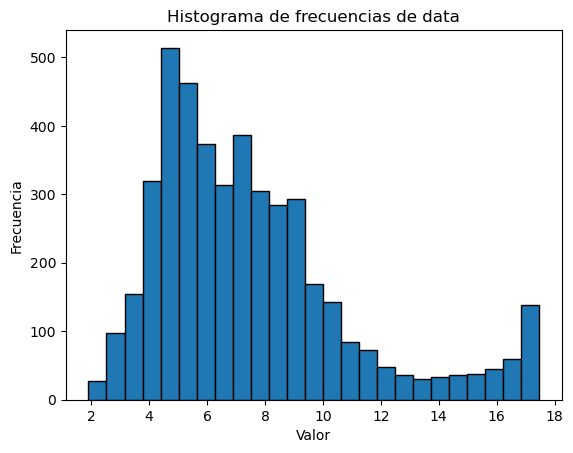

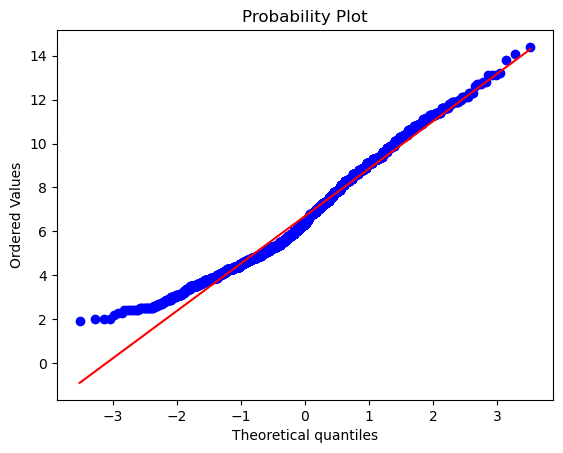

In [156]:
plt.hist(df_completo["data"].dropna(), bins = 25, edgecolor = "black")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.title("Histograma de frecuencias de data")
plt.show()

stats.probplot(df["data"].dropna(), dist="norm", plot=plt)
plt.show()

Observaciones del grafico Q - Q plot
* Es una herramienta para comparar los cuartiles de los datos (eje y), contra los cuartiles de una distribucion normal teorica (eje x). 
* La primera visectriz representa como se deberian ver los puntos si los datos siguieran una distribucion normal.

Muestra del Q - Q plot:
* Extremo inferior o cola izquierda: los puntos se alejan de la recta, entonces los datos tienen valores mas bajos que los que habria en una distrubucion normal.
* Centro : los puntos siguen bien la recta, por lo que en la parte central los datos se aproximan bastante a una distribucion normal.
* Extremo superior o cola derecha: hay un pequeño desvio de los datos pero mucho menor que la cola izquierda.

Conclusion: 
* Los datos son aproximadamente normales en el centro.
* En las colas la distribucion no es normal, ya que hay mas distribucion de la esperada con respecto a la normal.



<Axes: xlabel='fecha_hora'>

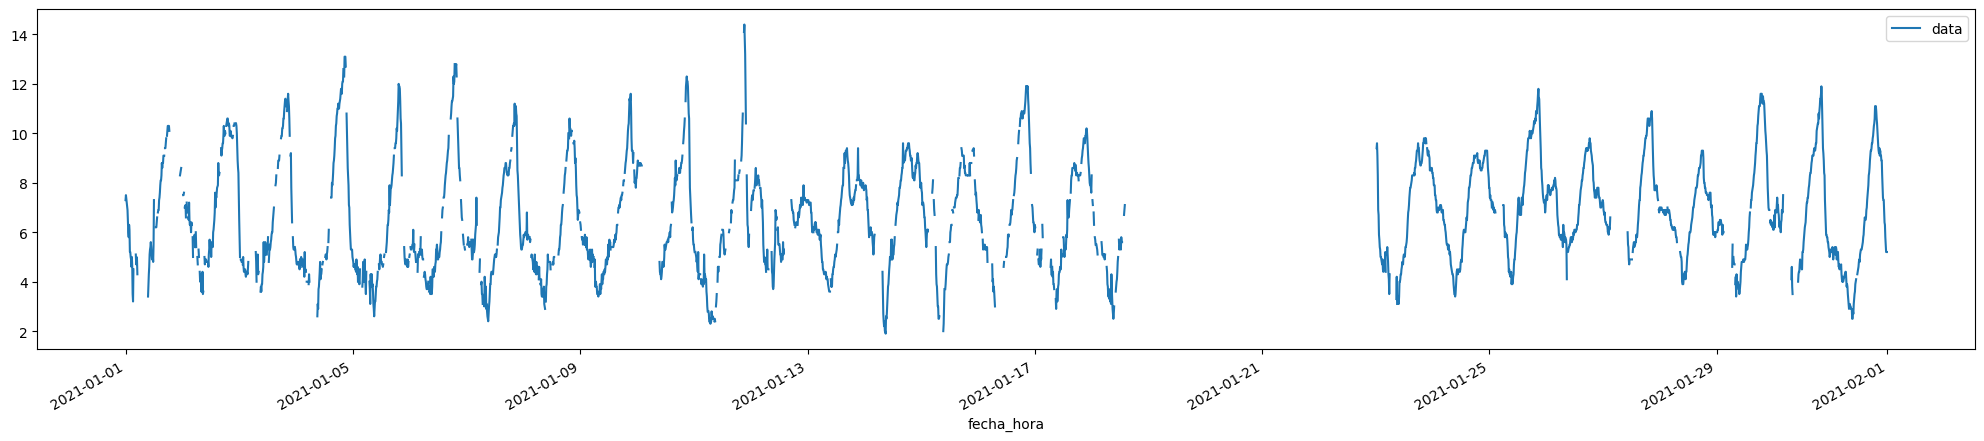

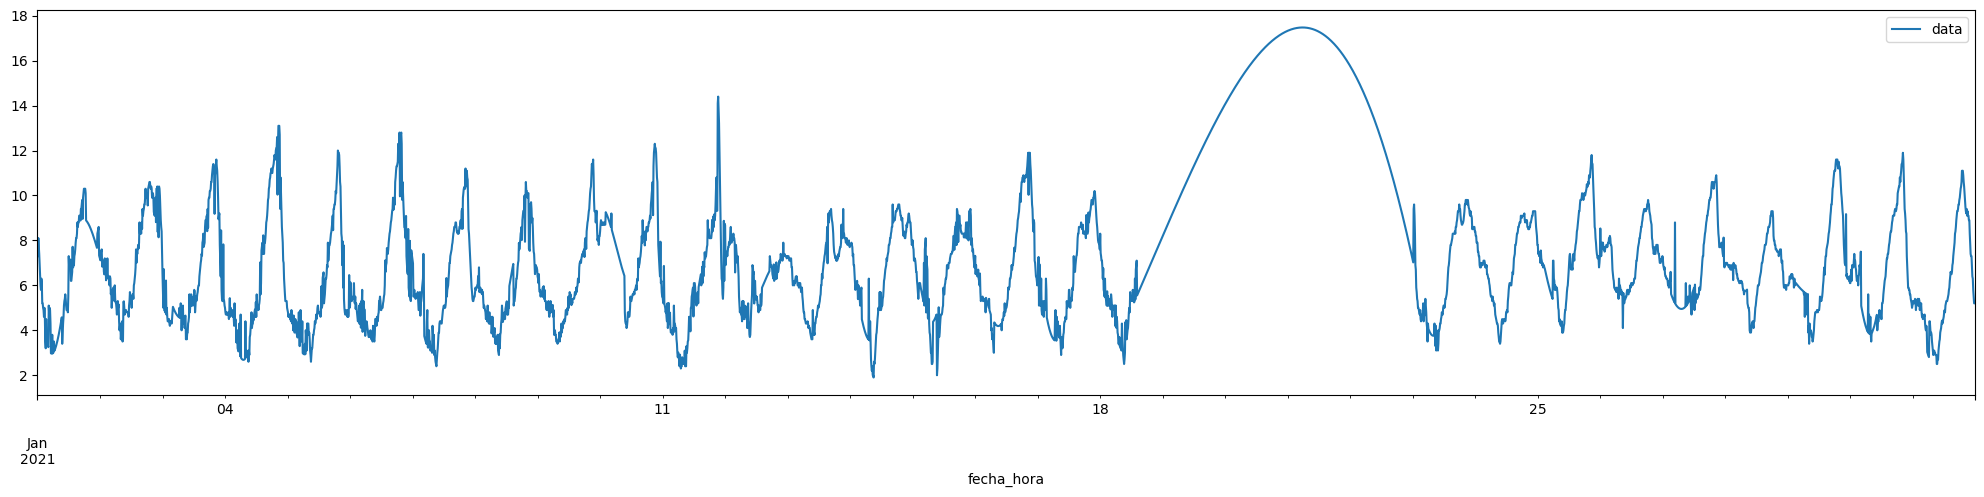

In [157]:
df.plot(x = "fecha_hora", y = "data", kind = "line", figsize=(25,5))
df_completo.plot(x = "fecha_hora", y = "data", kind = "line", figsize=(25,5))

In [158]:
inicio = "2021-01-22 00:00"
fin    = "2021-01-22 23:59"

filtro = (df_completo["fecha_hora"] >= inicio) & (df_completo["fecha_hora"] <= fin)

print(df_completo[filtro])

              fecha_hora      yy   mm    dd   time       data            diff
3024 2021-01-22 00:00:00  2021.0  1.0  22.0  00:00  15.751051 0 days 00:10:00
3025 2021-01-22 00:10:00  2021.0  1.0  22.0  00:10  15.717970 0 days 00:10:00
3026 2021-01-22 00:20:00  2021.0  1.0  22.0  00:20  15.684549 0 days 00:10:00
3027 2021-01-22 00:30:00  2021.0  1.0  22.0  00:30  15.650785 0 days 00:10:00
3028 2021-01-22 00:40:00  2021.0  1.0  22.0  00:40  15.616679 0 days 00:10:00
...                  ...     ...  ...   ...    ...        ...             ...
3163 2021-01-22 23:10:00  2021.0  1.0  22.0  23:10   7.554504 0 days 00:10:00
3164 2021-01-22 23:20:00  2021.0  1.0  22.0  23:20   7.466860 0 days 00:10:00
3165 2021-01-22 23:30:00  2021.0  1.0  22.0  23:30   7.378771 0 days 00:10:00
3166 2021-01-22 23:40:00  2021.0  1.0  22.0  23:40   7.290236 0 days 00:10:00
3167 2021-01-22 23:50:00  2021.0  1.0  22.0  23:50   7.201256 0 days 00:10:00

[144 rows x 7 columns]


Observaciones: 
* En los dias 18,19,20,21,22 habia mediciones pero el dato estaba corrupto. Es decir, el dato para esas mediciones estaban en NaN.
* Luego en el df_completo se realiza una interpolacion, para completar los datos faltantes tanto en las mediciones faltantes como con los datos corruptos.
* Como la interpolacion se realiza tomando dos puntos conocidos, y como tenemos muchos datos, elijo la interpolacion segmentada para evitar la inestabilidad de los polinomios de grado alto. Por ello, es que en
en esos dias con datos faltantes el grafico es un polinomio de grado 3.

* Con respecto a los ciclos, se observa en el grafico, que los datos se comportan de forma ciclica desde el dia 1 hasta el 18 oscilando entre [2,12] y desde el dia 23 hasta el 31 oscilando entre [3,11] en general, salvo en los casos donde hay valores alejados.
* Del dia 19 a 22 no tenemos informacion, pero siguiendo la tendencia de los datos, con la informacion previa y posterior a esos dias, podriamos deducir que en ese periodo de tiempo tambien los datos son ciclicos, oscilando entre [3,11] en general. 
Sin embargo, como esos datos estan interpolados, en el grafico se observa una mayor amplitud en la oscilacion. Pero es el valor matematico que aceptamos por interpolar esos datos. 


In [159]:

df_completo["media_5d"] = df_completo["data"].rolling(window=5).mean()

print(df_completo)

              fecha_hora      yy   mm    dd   time      data            diff  \
0    2021-01-01 00:00:00  2021.0  1.0   1.0  00:00  7.300000             NaT   
1    2021-01-01 00:10:00  2021.0  1.0   1.0  00:10  7.500000 0 days 00:10:00   
2    2021-01-01 00:20:00     NaN  NaN   NaN    NaN  8.105519             NaT   
3    2021-01-01 00:30:00     NaN  NaN   NaN    NaN  7.743513             NaT   
4    2021-01-01 00:40:00     NaN  NaN   NaN    NaN  7.396939             NaT   
...                  ...     ...  ...   ...    ...       ...             ...   
4459 2021-01-31 23:10:00  2021.0  1.0  31.0  23:10  5.800000 0 days 00:10:00   
4460 2021-01-31 23:20:00  2021.0  1.0  31.0  23:20  5.500000 0 days 00:10:00   
4461 2021-01-31 23:30:00  2021.0  1.0  31.0  23:30  5.200000 0 days 00:10:00   
4462 2021-01-31 23:40:00  2021.0  1.0  31.0  23:40  5.200000 0 days 00:10:00   
4463 2021-01-31 23:50:00  2021.0  1.0  31.0  23:50  5.200000 0 days 00:10:00   

      media_5d  
0          NaN  
1    

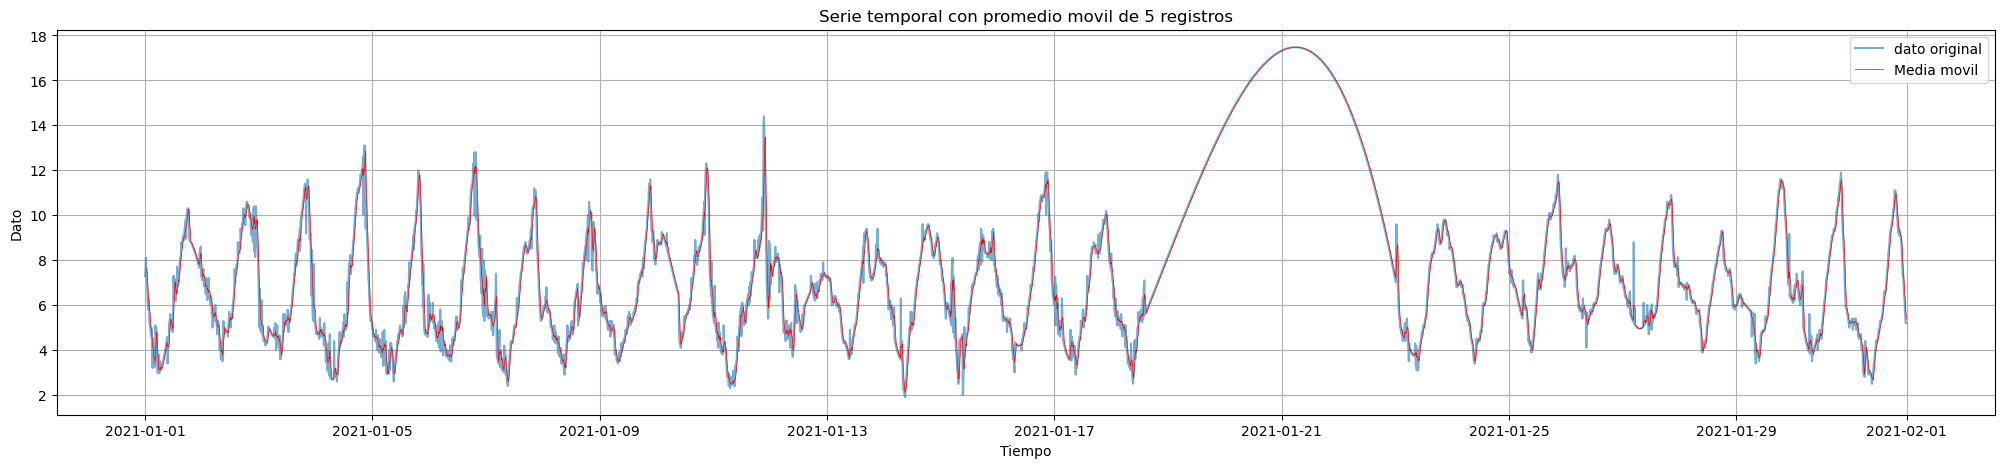

In [175]:

plt.figure(figsize=(25,5))
plt.plot(df_completo["fecha_hora"], df_completo["data"], label = "dato original", linewidth = 1.5, alpha = 0.6)
plt.plot(df_completo["fecha_hora"], df_completo["media_5d"], label = "Media movil", linewidth = 0.5, color = "red")
plt.xlabel("Tiempo")
plt.ylabel("Dato")
plt.title("Serie temporal con promedio movil de 5 registros")
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='fecha_hora'>

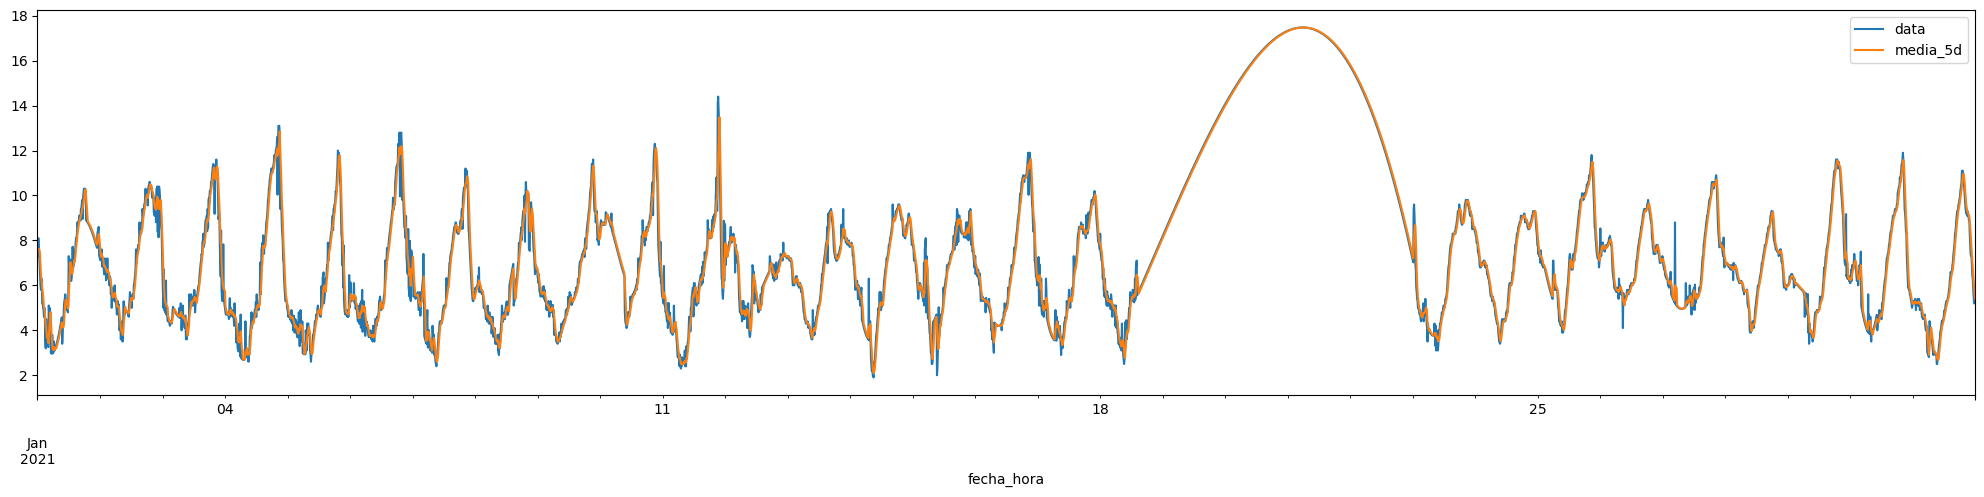

In [180]:

df_completo.plot(x="fecha_hora", y=["data", "media_5d"], figsize=(25,5))



# Segmento de datos para generar un modelo con algún algoritmo:

Un buen set de datos para entrenear un modelo debe ser representativo del fenomeno completo, es decir, debe presentar tanto comportamiento normal, como situaciones atipicas u excepciones.

Por ello el segmento de datos a elegir seria el que va desde 01/01/2001 hasta el 18/01/2021, ya que en ese periodo tenemos una muestra de datos homogenea, donde hay pocos datos faltantes y contiene los valores alejados. Esto lo hace un set de datos representativo que permite realizar diferentes analisis:
* Tendencias: al tener la mayor cantidad de datos, es posible evaluar si estos presentan comportamiento ciclicos o algun patron.
* Eventos extraordinarios: al contener los valores alejados, podemos analizar las situaciones atipicas y comprender como se comporta el fenomeno en observacion en este escenario.

En el intervalo de tiempo de 19 al 22 no tenemos datos directamente. 

Con respecto al periodo del 23 al 31, tiene menos datos faltantes que el periodo elegido, pero es menos representativo y la falta de diversisdad en la muestra no se puede corregir de forma artificial, mientras que la falta de algunos datos se puede solucionar imputando mediante interpolacion u otras tecnicas.

